In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =5e-25

nband = 80

ng =5

ng_refs = (/ 5 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =300

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

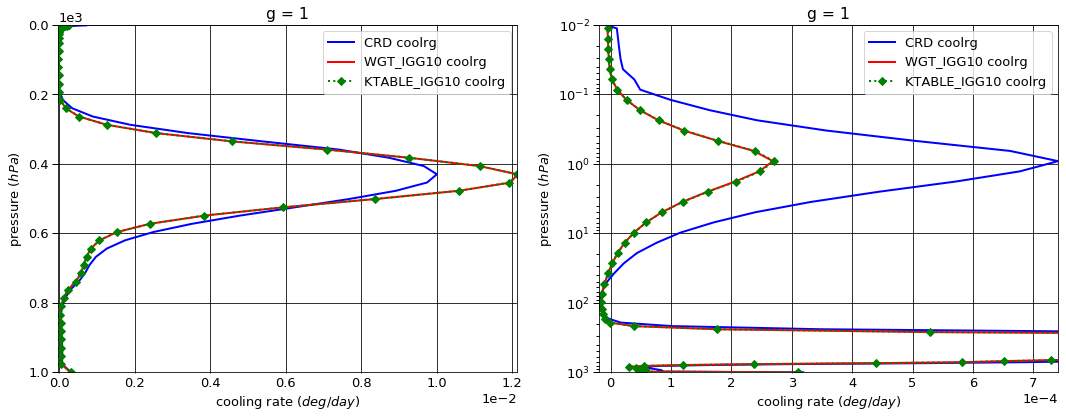

# Figure: cooling rate g-group 2

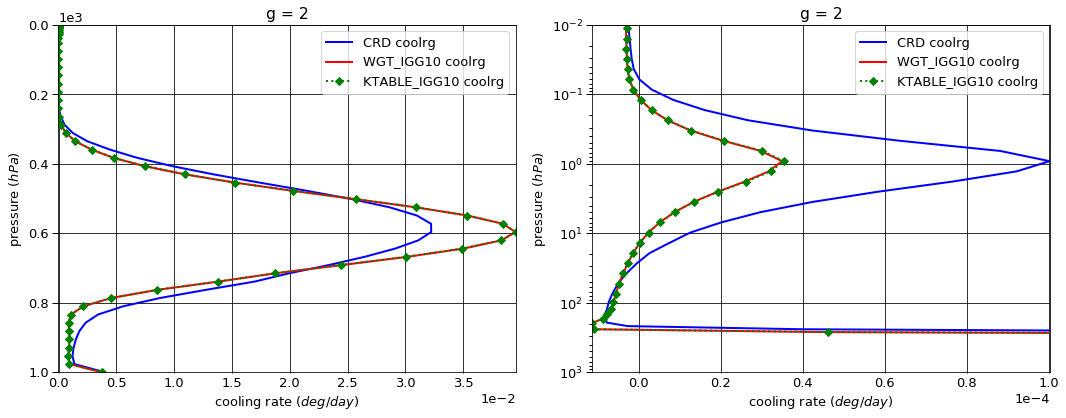

# Figure: cooling rate g-group 3

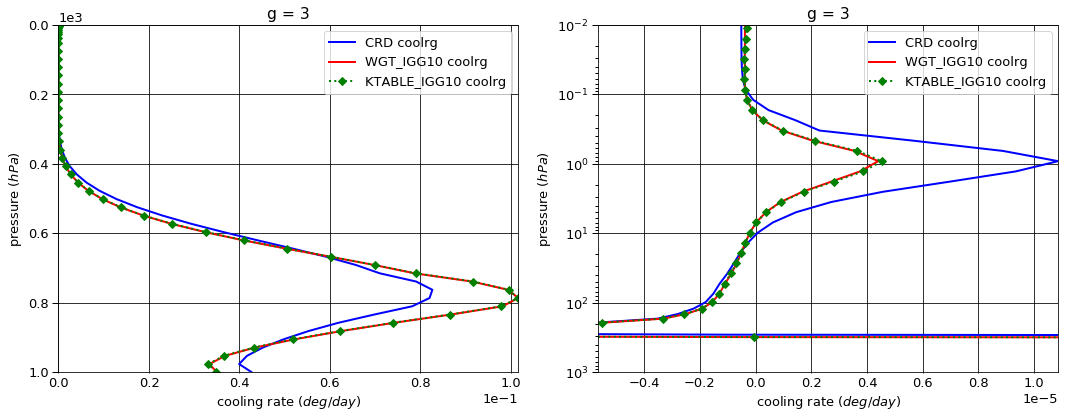

# Figure: cooling rate g-group 4

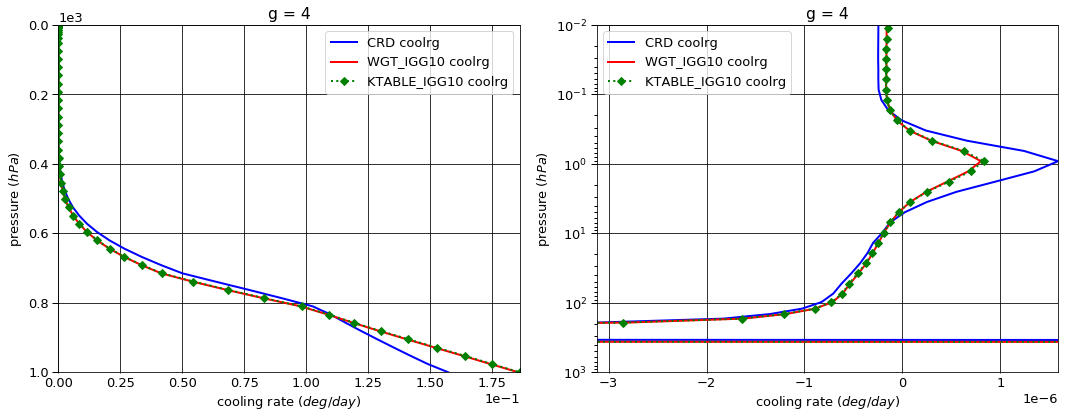

# Figure: cooling rate g-group 5

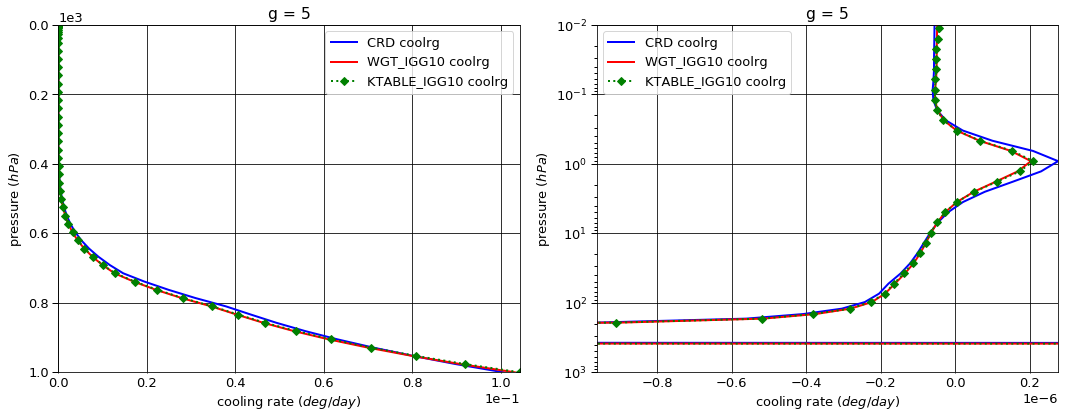

# Figure: cooling rate g-group total

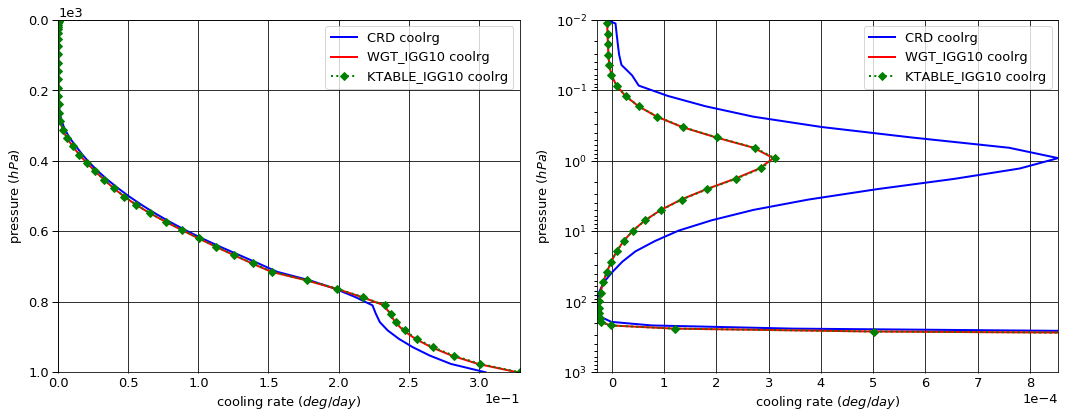

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.278684  0.000000  -0.278684
  1013.0   76     -0.544363  0.543561  -0.000802
2 0.0      1      -1.190255  0.000000  -1.190255
  1013.0   76     -1.825069  1.812514  -0.012555
3 0.0      1      -3.661793  0.000000  -3.661793
  1013.0   76     -4.519021  4.133275  -0.385745
4 0.0      1      -9.481777  0.000000  -9.481777
  1013.0   76    -10.198932  5.266770  -4.932162
5 0.0      1     -17.880451  0.000000 -17.880451
  1013.0   76    -18.136125  2.297678 -15.838447


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.278896  0.000000  -0.278896
  1013.0   76     -0.544363  0.543553  -0.000810
2 0.0      1      -1.192004  0.000000  -1.192004
  1013.0   76     -1.825069  1.814821  -0.010248
3 0.0      1      -3.648847  0.000000  -3.648847
  1013.0   76     -4.519021  4.335742  -0.183278
4 0.0      1      -9.538832  0.000000  -9.538832
  1013.0   76    -10.198932  5.299759  -4.899173
5 0.0      1     -17.901433  0.000000 -17.901433
  1013.0   76    -18.136125  2.194300 -15.941825


KTABLE_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.278796  0.000000  -0.278796
  1013.0   76     -0.544363  0.543555  -0.000808
2 0.0      1      -1.191409  0.000000  -1.191409
  1013.0   76     -1.825069  1.814826  -0.010242
3 0.0      1      -3.646692  0.000000  -3.646692
  1013.0   76     -4.519021  4.337378  -0.181643
4 0.0      1      -9.534775  0.000000  -9.534775
  1013.0   76    -10.198932  5.327019  -4.871913
5 0.0      1     -17.899095  0.000000 -17.899095
  1013.0   76    -18.136125  2.216848 -15.919277


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -2.122600e-04  0.000000 -0.000212
  1013.0   76     0.000000e+00 -0.000008 -0.000008
2 0.0      1     -1.748700e-03  0.000000 -0.001749
  1013.0   76    -2.220446e-16  0.002307  0.002307
3 0.0      1      1.294570e-02  0.000000  0.012946
  1013.0   76     8.881784e-16  0.202467  0.202467
4 0.0      1     -5.705540e-02  0.000000 -0.057055
  1013.0   76     1.776357e-15  0.032989  0.032989
5 0.0      1     -2.098200e-02  0.000000 -0.020982
  1013.0   76     0.000000e+00 -0.103378 -0.103378


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.118100e-04  0.000000 -0.000112
  1013.0   76     0.000000e+00 -0.000007 -0.000007
2 0.0      1     -1.154000e-03  0.000000 -0.001154
  1013.0   76    -2.220446e-16  0.002312  0.002312
3 0.0      1      1.510050e-02  0.000000  0.015100
  1013.0   76     8.881784e-16  0.204102  0.204102
4 0.0      1     -5.299830e-02  0.000000 -0.052998
  1013.0   76     1.776357e-15  0.060249  0.060249
5 0.0      1     -1.864400e-02  0.000000 -0.018644
  1013.0   76     0.000000e+00 -0.080831 -0.080830

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.149115e-06
  1001.112500 75     3.192633e-04
2 0.000312    1     -4.129522e-06
  1001.112500 75     4.010527e-03
3 0.000312    1     -5.062637e-07
  1001.112500 75     4.273382e-02
4 0.000312    1     -2.342310e-07
  1001.112500 75     1.572941e-01
5 0.000312    1     -5.163505e-08
  1001.112500 75     1.006385e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -9.644947e-06
  1001.112500 75     3.104630e-04
2 0.000312    1     -3.598870e-06
  1001.112500 75     3.757106e-03
3 0.000312    1     -3.516047e-07
  1001.112500 75     3.504083e-02
4 0.000312    1     -1.512547e-07
  1001.112500 75     1.855830e-01
5 0.000312    1     -4.495852e-08
  1001.112500 75     1.032143e-01


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -7.447531e-06
  1001.112500 75     3.100645e-04
2 0.000312    1     -2.921364e-06
  1001.112500 75     3.757440e-03
3 0.000312    1     -1.384000e-07
  1001.112500 75     3.484927e-02
4 0.000312    1     -9.676169e-08
  1001.112500 75     1.861652e-01
5 0.000312    1     -2.420843e-08
  1001.112500 75     1.043373e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -6.495832e-06
  1001.112500 75    -8.800310e-06
2 0.000312    1      5.306522e-07
  1001.112500 75    -2.534210e-04
3 0.000312    1      1.546590e-07
  1001.112500 75    -7.692987e-03
4 0.000312    1      8.297633e-08
  1001.112500 75     2.828892e-02
5 0.000312    1      6.676532e-09
  1001.112500 75     2.575790e-03


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.298415e-06
  1001.112500 75    -9.198800e-06
2 0.000312    1      1.208158e-06
  1001.112500 75    -2.530872e-04
3 0.000312    1      3.678637e-07
  1001.112500 75    -7.884551e-03
4 0.000312    1      1.374693e-07
  1001.112500 75     2.887112e-02
5 0.000312    1      2.742662e-08
  1001.112500 75     3.698770e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.49296,0.000000,-32.492960
1013.0,76,-35.22351,14.053799,-21.169711



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.560012,0.000000,-32.560012
1013.0,76,-35.223510,14.188175,-21.035334



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-32.550767,0.000000,-32.550767
1013.0,76,-35.223510,14.239626,-20.983884



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.067053,0.000000,-0.067053
1013.0,76,0.000000,0.134376,0.134376



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.057808,0.000000,-0.057808
1013.0,76,0.000000,0.185827,0.185827


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.304996



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.327906



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000011
1001.112500,75,0.329419



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.022910



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.024423


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015500,0.015423
2,0.052000,0.051652
3,0.128688,0.127952
4,0.290063,0.289068
5,0.513750,0.515905


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.501949e-22
2,2.243039e-23
3,3.349798e-24
4,5.002654e-25
5,3.765264e-26


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.501949e-22,NaN,0.015500,0.015423,0.015500,0.015423,600.0
2,2.243039e-23,0.149342,0.052000,0.051652,0.067500,0.067075,600.0
3,3.349798e-24,0.149342,0.128688,0.127952,0.196188,0.195027,600.0
4,5.002654e-25,0.149342,0.290063,0.289068,0.486250,0.484095,600.0
5,3.765264e-26,0.075265,0.513750,0.515905,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.361595e-22  7.723004e-24  30.578705  8.437532e-09
      2 0.000312     1.063151e-23  2.631985e-25  40.393529  3.769213e-10
      3 0.000312     2.016399e-25  1.411261e-26  14.287920  8.761895e-12
      4 0.000312     2.490977e-26  2.765614e-27   9.006959  1.263923e-12
      5 0.000312     2.836060e-27  1.686420e-28  16.817041  1.777799e-13
2     1 0.000750     2.378870e-22  7.742215e-24  30.725956  3.422866e-09
      2 0.000750     1.069036e-23  2.642800e-25  40.450865  1.526539e-10
      3 0.000750     2.042120e-25  1.415346e-26  14.428419  3.572641e-12
      4 0.000750     2.514372e-26  2.779934e-27   9.044716  5.137754e-13
      5 0.000750     2.864847e-27  1.695206e-28  16.899706  7.233192e-14
3     1 0.001052     2.414276e-22  7.778543e-24  31.037643  4.870082e-09
      2 0.001052     1.081128e-23  2.663691e-25  40.587606  2.164837e-10
      3 0.001052     2.095281e-25  1.422932e-26  14.725095  5.136072e-12
      4 0.001052     2.562480e-26  2.808327e-27   9.124578  7.340062e-13
      5 0.001052     2.924167e-27  1.712004e-28  17.080378  1.035305e-13
4     1 0.001476     2.450658e-22  7.815744e-24  31.355407  6.932962e-09
      2 0.001476     1.093598e-23  2.685378e-25  40.724175  3.071814e-10
      3 0.001476     2.150623e-25  1.430489e-26  15.034177  7.389083e-12
      4 0.001476     2.612304e-26  2.837593e-27   9.206057  1.049337e-12
      5 0.001476     2.985787e-27  1.729437e-28  17.264502  1.482925e-13
5     1 0.002070     2.487534e-22  7.853565e-24  31.673952  9.867336e-09
      2 0.002070     1.106284e-23  2.707696e-25  40.857006  4.358124e-10
      3 0.002070     2.207465e-25  1.437965e-26  15.351308  1.062842e-11
      4 0.002070     2.663224e-26  2.867441e-27   9.287806  1.499886e-12
      5 0.002070     3.048946e-27  1.747406e-28  17.448414  2.123785e-13
6     1 0.002904     2.524893e-22  7.892333e-24  31.991723  1.404489e-08
      2 0.002904     1.119184e-23  2.730824e-25  40.983364  6.184133e-10
      3 0.002904     2.265825e-25  1.445430e-26  15.675781  1.528986e-11
      4 0.002904     2.715257e-26  2.897995e-27   9.369435  2.144230e-12
      5 0.002904     3.113672e-27  1.766076e-28  17.630455  3.042158e-13
7     1 0.004074     2.562729e-22  7.932545e-24  32.306518  1.999113e-08
      2 0.004074     1.132298e-23  2.755019e-25  41.099463  8.776001e-10
      3 0.004074     2.325733e-25  1.452991e-26  16.006523  2.199674e-11
      4 0.004074     2.768436e-26  2.929433e-27   9.450413  3.065628e-12
      5 0.004074     3.180007e-27  1.785683e-28  17.808346  4.358101e-13
8     1 0.005714     2.601057e-22  7.974931e-24  32.615423  2.845245e-08
      2 0.005714     1.145637e-23  2.780665e-25  41.200099  1.245421e-09
      3 0.005714     2.387259e-25  1.460803e-26  16.342101  3.164462e-11
      4 0.005714     2.822831e-26  2.962033e-27   9.530047  4.382997e-12
      5 0.005714     3.248045e-27  1.806573e-28  17.979038  6.243446e-13
9     1 0.008015     2.639853e-22  8.020489e-24  32.913865  4.049502e-08
      2 0.008015     1.159194e-23  2.808274e-25  41.277791  1.767564e-09
      3 0.008015     2.450411e-25  1.469082e-26  16.679881  4.552645e-11
      4 0.008015     2.878470e-26  2.996145e-27   9.607245  6.267106e-12
      5 0.008015     3.317821e-27  1.829209e-28  18.138006  8.945431e-13
10    1 0.011243     2.679111e-22  8.070664e-24  33.195671  5.763244e-08
      2 0.011243     1.172972e-23  2.838595e-25  41.322259  2.508759e-09
      3 0.011243     2.515238e-25  1.478138e-26  17.016260  6.549935e-11
      4 0.011243     2.935423e-26  3.032293e-27   9.680537  8.961870e-12
      5 0.011243     3.389429e-27  1.854264e-28  18.279112  1.281792e-12
11    1 0.015771     2.718813e-22  8.127487e-24  33.452081  8.202162e-08
      2 0.015771     1.186971e-23  2.872683e-25  41.319237  3.561083e-09
      3 0.015771     2.581778e-25  1.488410e-26  17.345881  9.424006e-11
      4 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
